# **Initialization**

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!sudo apt-get install xvfb
!pip install swig
!pip install gym[box2d]

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
from IPython.display import HTML
from IPython import display as ipythondisplay
import glob
import io
import base64
import pygame
import numpy as np
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
import seaborn as sns
sns.set()
gymlogger.set_level(40) #error only
pygame.init()
pygame.font.init()

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

def wrap_env(env):
  env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
  return env

# **Test a random agent**

In [ ]:
env = wrap_env(gym.make("MountainCar-v0"))
observation = env.reset()
done = False
while not done:

    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

env.close()
show_video()

# **Create Env**

In [ ]:
env = gym.make('MountainCar-v0')

In [ ]:
env.reset()

array([-0.5383109,  0.       ], dtype=float32)

In [ ]:
env.action_space.n

3

In [ ]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

# **Discretization for Q-Table**

In [ ]:
np.linspace(0, 10, 5)

array([ 0. ,  2.5,  5. ,  7.5, 10. ])

In [ ]:
np.array([[0, 1, 5, 6], [-1, 5, 9, 7]])

array([[ 0,  1,  5,  6],
       [-1,  5,  9,  7]])

In [ ]:
def create_bins(num_bins):
    car_position = np.linspace(-1.2, 0.6, num_bins)
    car_velocity = np.linspace(-0.07, 0.07, num_bins)
    bins = np.array([car_position, car_velocity])
    return bins

In [ ]:
NUM_BINS = 40

In [ ]:
BINS = create_bins(40)

In [ ]:
BINS

array([[-1.2       , -1.15384615, -1.10769231, -1.06153846, -1.01538462,
        -0.96923077, -0.92307692, -0.87692308, -0.83076923, -0.78461538,
        -0.73846154, -0.69230769, -0.64615385, -0.6       , -0.55384615,
        -0.50769231, -0.46153846, -0.41538462, -0.36923077, -0.32307692,
        -0.27692308, -0.23076923, -0.18461538, -0.13846154, -0.09230769,
        -0.04615385,  0.        ,  0.04615385,  0.09230769,  0.13846154,
         0.18461538,  0.23076923,  0.27692308,  0.32307692,  0.36923077,
         0.41538462,  0.46153846,  0.50769231,  0.55384615,  0.6       ],
       [-0.07      , -0.06641026, -0.06282051, -0.05923077, -0.05564103,
        -0.05205128, -0.04846154, -0.04487179, -0.04128205, -0.03769231,
        -0.03410256, -0.03051282, -0.02692308, -0.02333333, -0.01974359,
        -0.01615385, -0.0125641 , -0.00897436, -0.00538462, -0.00179487,
         0.00179487,  0.00538462,  0.00897436,  0.0125641 ,  0.01615385,
         0.01974359,  0.02333333,  0.02692308,  0.

In [ ]:
bin1 = np.linspace(0, 10, 5)
bin1

array([ 0. ,  2.5,  5. ,  7.5, 10. ])

In [ ]:
np.digitize(9.99999, bin1)

4

In [ ]:
(1, 2, 3, 4, 5) + (1,)

(1, 2, 3, 4, 5, 1)

In [ ]:
def discretize_states(states, bins):
    binned_states = []
    for i, state in enumerate(states):
        discretized_state = np.digitize(state, bins[i])
        binned_states.append(discretized_state)

    return tuple(binned_states)

In [ ]:
observation = env.reset()

In [ ]:
print(f"Car Position: {observation[0]}")
print(f"Car Velocity: {observation[1]}")
print(f"Car Position Discrete: {discretize_states(observation, BINS)[0]}")
print(f"Car Velocity Discrete: {discretize_states(observation, BINS)[1]}")

Car Position: -0.515530526638031
Car Velocity: 0.0
Car Position Discrete: 15
Car Velocity Discrete: 20


In [ ]:
Q = np.zeros((NUM_BINS, NUM_BINS, env.action_space.n))

In [ ]:
Q.shape

(40, 40, 3)

# **Epsilon Greedy Policy**

In [ ]:
def policy(epsilon, Q, state):
    if np.random.random() > epsilon:
        action = np.argmax(Q[state])
    else:
        action = env.action_space.sample()

    return action

In [ ]:
def reduce_epsilon(epsilon, episode):
    if BURN_IN <= episode <= EPSILON_END:
        epsilon -= EPSILON_DECAY

    return epsilon

# **Training the model**

In [ ]:
ALPHA = 0.1
GAMMA = 0.99
epsilon = 1
BURN_IN = 100
EPSILON_END = 10000
EPSILON_DECAY = 0.0001
train_episodes = 30000

In [ ]:
from tqdm import tqdm

In [ ]:
training_rewards = []
training_rewards_mean = []
epsilons = []
log_interval = 500

for episode in tqdm(range(train_episodes)):
    state = env.reset()
    state = discretize_states(state, BINS)
    total_training_reward = 0
    done = False
    while not done:
        action = policy(epsilon, Q, state)
        new_state, reward, done, info = env.step(action)
        new_state = discretize_states(new_state, BINS)
        Q[state + (action,)] = Q[state + (action,)] + ALPHA * (reward + GAMMA * np.max(Q[new_state]) - Q[state + (action,)])
        total_training_reward += reward
        state = new_state


    if episode % log_interval == 0:
        mean_rewards = np.mean(training_rewards[-100:])
        print(f"Mean Reward = {mean_rewards}, Epsilon = {epsilon}")
        if episode != 0:
            training_rewards_mean.append(mean_rwards)

    epsilon = reduce_epsilon(epsilon, episode)
    training_rewards.append(total_training_reward)
    epsilons.append(epsilon)

  0%|          | 18/30000 [00:00<05:33, 89.96it/s]

Mean Reward = nan, Epsilon = 1


  2%|▏         | 512/30000 [00:06<05:20, 92.01it/s]

Mean Reward = -200.0, Epsilon = 0.9600000000000044


  3%|▎         | 1018/30000 [00:12<05:24, 89.39it/s]

Mean Reward = -200.0, Epsilon = 0.9100000000000099


  5%|▌         | 1511/30000 [00:18<04:59, 95.17it/s]

Mean Reward = -200.0, Epsilon = 0.8600000000000154


  7%|▋         | 2007/30000 [00:23<06:02, 77.21it/s]

Mean Reward = -200.0, Epsilon = 0.8100000000000209


  8%|▊         | 2510/30000 [00:29<05:33, 82.48it/s]

Mean Reward = -200.0, Epsilon = 0.7600000000000264


 10%|█         | 3010/30000 [00:35<05:38, 79.82it/s]

Mean Reward = -200.0, Epsilon = 0.7100000000000319


 12%|█▏        | 3513/30000 [00:42<05:10, 85.26it/s]

Mean Reward = -200.0, Epsilon = 0.6600000000000374


 13%|█▎        | 4016/30000 [00:49<05:48, 74.51it/s]

Mean Reward = -200.0, Epsilon = 0.610000000000043


 15%|█▌        | 4513/30000 [00:57<05:17, 80.35it/s]

Mean Reward = -200.0, Epsilon = 0.5600000000000485


 17%|█▋        | 5015/30000 [01:03<04:38, 89.56it/s]

Mean Reward = -200.0, Epsilon = 0.510000000000054


 18%|█▊        | 5520/30000 [01:09<04:31, 90.32it/s]

Mean Reward = -199.66, Epsilon = 0.4600000000000595


 20%|██        | 6008/30000 [01:15<05:21, 74.51it/s]

Mean Reward = -197.82, Epsilon = 0.410000000000065


 22%|██▏       | 6510/30000 [01:22<05:36, 69.87it/s]

Mean Reward = -198.62, Epsilon = 0.3600000000000705


 23%|██▎       | 7014/30000 [01:27<04:40, 81.88it/s]

Mean Reward = -196.77, Epsilon = 0.310000000000076


 25%|██▌       | 7515/30000 [01:33<04:15, 87.90it/s]

Mean Reward = -191.11, Epsilon = 0.2600000000000815


 27%|██▋       | 8015/30000 [01:39<04:28, 81.89it/s]

Mean Reward = -195.02, Epsilon = 0.210000000000087


 28%|██▊       | 8513/30000 [01:45<04:12, 85.14it/s]

Mean Reward = -191.19, Epsilon = 0.1600000000000925


 30%|███       | 9015/30000 [01:51<03:46, 92.51it/s]

Mean Reward = -184.43, Epsilon = 0.11000000000009594


 32%|███▏      | 9515/30000 [01:57<03:35, 94.95it/s]

Mean Reward = -195.31, Epsilon = 0.060000000000094506


 33%|███▎      | 10018/30000 [02:03<03:27, 96.07it/s]

Mean Reward = -174.48, Epsilon = 0.010000000000093812


 35%|███▌      | 10506/30000 [02:08<03:30, 92.40it/s] 

Mean Reward = -174.35, Epsilon = 0.009900000000093813


 37%|███▋      | 11018/30000 [02:14<03:12, 98.82it/s]

Mean Reward = -184.78, Epsilon = 0.009900000000093813


 38%|███▊      | 11520/30000 [02:19<03:33, 86.43it/s]

Mean Reward = -172.93, Epsilon = 0.009900000000093813


 40%|████      | 12027/30000 [02:24<02:33, 117.29it/s]

Mean Reward = -150.76, Epsilon = 0.009900000000093813


 42%|████▏     | 12512/30000 [02:28<02:39, 109.48it/s]

Mean Reward = -166.58, Epsilon = 0.009900000000093813


 43%|████▎     | 13012/30000 [02:34<03:13, 88.01it/s]

Mean Reward = -189.29, Epsilon = 0.009900000000093813


 45%|████▌     | 13515/30000 [02:38<02:25, 113.26it/s]

Mean Reward = -161.97, Epsilon = 0.009900000000093813


 47%|████▋     | 14025/30000 [02:44<02:37, 101.60it/s]

Mean Reward = -166.82, Epsilon = 0.009900000000093813


 48%|████▊     | 14517/30000 [02:48<02:43, 94.53it/s]

Mean Reward = -173.5, Epsilon = 0.009900000000093813


 50%|█████     | 15017/30000 [02:53<01:57, 127.36it/s]

Mean Reward = -148.43, Epsilon = 0.009900000000093813


 52%|█████▏    | 15519/30000 [02:58<02:17, 105.41it/s]

Mean Reward = -160.33, Epsilon = 0.009900000000093813


 53%|█████▎    | 16013/30000 [03:03<02:30, 93.18it/s]

Mean Reward = -171.06, Epsilon = 0.009900000000093813


 55%|█████▌    | 16513/30000 [03:07<02:29, 90.50it/s]

Mean Reward = -143.69, Epsilon = 0.009900000000093813


 57%|█████▋    | 17022/30000 [03:12<01:48, 119.13it/s]

Mean Reward = -146.86, Epsilon = 0.009900000000093813


 58%|█████▊    | 17519/30000 [03:16<01:43, 120.07it/s]

Mean Reward = -152.27, Epsilon = 0.009900000000093813


 60%|██████    | 18014/30000 [03:21<01:48, 110.59it/s]

Mean Reward = -151.92, Epsilon = 0.009900000000093813


 62%|██████▏   | 18516/30000 [03:25<01:41, 113.04it/s]

Mean Reward = -157.61, Epsilon = 0.009900000000093813


 63%|██████▎   | 19018/30000 [03:29<01:22, 133.13it/s]

Mean Reward = -140.56, Epsilon = 0.009900000000093813


 65%|██████▌   | 19520/30000 [03:34<01:37, 107.51it/s]

Mean Reward = -147.22, Epsilon = 0.009900000000093813


 67%|██████▋   | 20022/30000 [03:38<01:23, 119.57it/s]

Mean Reward = -150.22, Epsilon = 0.009900000000093813


 68%|██████▊   | 20520/30000 [03:43<01:37, 96.97it/s]

Mean Reward = -159.56, Epsilon = 0.009900000000093813


 70%|███████   | 21021/30000 [03:48<01:19, 112.31it/s]

Mean Reward = -165.11, Epsilon = 0.009900000000093813


 72%|███████▏  | 21522/30000 [03:52<01:06, 126.82it/s]

Mean Reward = -136.04, Epsilon = 0.009900000000093813


 73%|███████▎  | 22014/30000 [03:57<01:27, 91.43it/s]

Mean Reward = -131.24, Epsilon = 0.009900000000093813


 75%|███████▌  | 22523/30000 [04:01<00:55, 135.75it/s]

Mean Reward = -130.75, Epsilon = 0.009900000000093813


 77%|███████▋  | 23029/30000 [04:05<00:51, 135.90it/s]

Mean Reward = -136.06, Epsilon = 0.009900000000093813


 78%|███████▊  | 23515/30000 [04:09<01:08, 94.01it/s]

Mean Reward = -135.41, Epsilon = 0.009900000000093813


 80%|████████  | 24022/30000 [04:13<00:45, 130.73it/s]

Mean Reward = -133.85, Epsilon = 0.009900000000093813


 82%|████████▏ | 24525/30000 [04:17<00:41, 131.97it/s]

Mean Reward = -127.92, Epsilon = 0.009900000000093813


 83%|████████▎ | 25014/30000 [04:21<00:55, 89.59it/s]

Mean Reward = -127.32, Epsilon = 0.009900000000093813


 85%|████████▌ | 25516/30000 [04:25<00:33, 132.65it/s]

Mean Reward = -131.73, Epsilon = 0.009900000000093813


 87%|████████▋ | 26009/30000 [04:29<00:40, 99.13it/s] 

Mean Reward = -158.11, Epsilon = 0.009900000000093813


 88%|████████▊ | 26508/30000 [04:37<00:43, 80.08it/s]

Mean Reward = -137.0, Epsilon = 0.009900000000093813


 90%|█████████ | 27016/30000 [04:42<00:22, 131.44it/s]

Mean Reward = -134.22, Epsilon = 0.009900000000093813


 92%|█████████▏| 27512/30000 [04:47<00:44, 55.35it/s]

Mean Reward = -142.39, Epsilon = 0.009900000000093813


 93%|█████████▎| 28017/30000 [04:52<00:17, 112.43it/s]

Mean Reward = -148.29, Epsilon = 0.009900000000093813


 95%|█████████▌| 28519/30000 [04:56<00:12, 117.84it/s]

Mean Reward = -142.27, Epsilon = 0.009900000000093813


 97%|█████████▋| 29004/30000 [05:03<00:24, 41.01it/s]

Mean Reward = -134.12, Epsilon = 0.009900000000093813


 98%|█████████▊| 29516/30000 [05:08<00:03, 122.27it/s]

Mean Reward = -132.11, Epsilon = 0.009900000000093813


100%|██████████| 30000/30000 [05:13<00:00, 95.64it/s] 


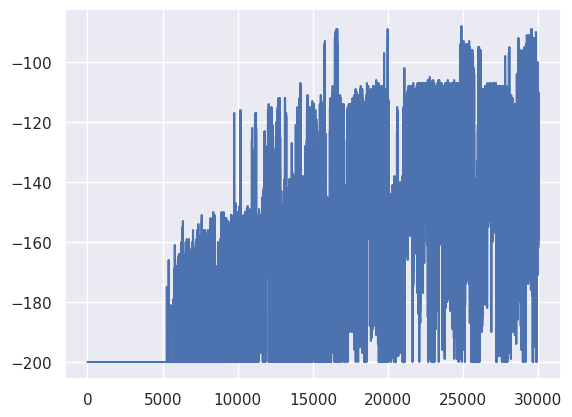

In [ ]:
x = range(train_episodes)
plt.plot(x, training_rewards)

# **Testing trained model**

In [ ]:
env_test = wrap_env(gym.make("MountainCar-v0"))
state = env_test.reset()
state = discretize_states(state, BINS)
done = False
while not done:

    env_test.render()
    action = np.argmax(Q[state])
    new_state, reward, done, info = env_test.step(action)
    state = discretize_states(new_state, BINS)

env_test.close()
show_video()